In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [16]:
df = pd.read_csv('../../mlops_data/train.csv')

/tmp/ipykernel_656946/1186843771.py:1: DtypeWarning: Columns (16,17,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../mlops_data/train.csv')


In [17]:
def create_lstm_sequences(values, window_size=5):
    X, y = [], []
    for i in range(len(values) - window_size):
        X.append(values[i:i+window_size])
        y.append(values[i+window_size])
    return X, y

In [ ]:
df["계약일자"] = pd.to_datetime(df["계약년월"].astype(str) + df["계약일"].astype(str).str.zfill(2), format="%Y%m%d")
df["단지ID"] = df["시군구"].str.strip() + "_" + df["아파트명"].str.strip()
df = df.sort_values(by=["단지ID", "계약일자"])

all_X, all_y = [], []
for _, group in df.groupby("단지ID"):
    values = group["target"].tolist()
    if len(values) > 5:
        X_seq, y_seq = create_lstm_sequences(values, window_size=5)
        all_X.extend(X_seq)
        all_y.extend(y_seq)

In [20]:
X_tensor = torch.tensor(all_X, dtype=torch.float32).unsqueeze(-1)
y_tensor = torch.tensor(all_y, dtype=torch.float32).unsqueeze(1)

In [23]:
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

In [24]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)

In [25]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [27]:
model = LSTMModel().to(device)
creterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [28]:
train_losses, val_losses = [], []
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        pred = model(X_batch)
        loss = creterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            pred = model(X_batch)
            loss = creterion(pred, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch [1/20] - Train Loss: 5541731585.2920, Val Loss: 5538895037.5075
Epoch [2/20] - Train Loss: 5501606216.5988, Val Loss: 5497880528.9554
Epoch [3/20] - Train Loss: 5460234933.4832, Val Loss: 5456836731.3169
Epoch [4/20] - Train Loss: 5419358910.0956, Val Loss: 5416048173.1376
Epoch [5/20] - Train Loss: 5377296931.4321, Val Loss: 5372807000.6012
Epoch [6/20] - Train Loss: 5334971690.6044, Val Loss: 5331039524.0663
Epoch [7/20] - Train Loss: 5293407226.9026, Val Loss: 5289561822.7347
Epoch [8/20] - Train Loss: 5252129559.0613, Val Loss: 5248365464.7278
Epoch [9/20] - Train Loss: 5211094312.8906, Val Loss: 5207400398.5539
Epoch [10/20] - Train Loss: 5170334447.3959, Val Loss: 5166738920.4052
Epoch [11/20] - Train Loss: 5129889429.6731, Val Loss: 5126367375.6518
Epoch [12/20] - Train Loss: 5089708756.0177, Val Loss: 5086242342.8531
Epoch [13/20] - Train Loss: 5049774712.4403, Val Loss: 5046405781.7461
Epoch [14/20] - Train Loss: 5010128360.6153, Val Loss: 5006847281.1228
Epoch [15/20] -

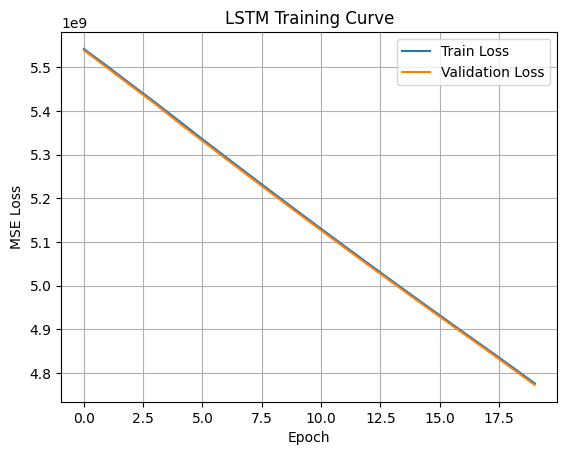

In [30]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("LSTM Training Curve")
plt.legend()
plt.grid(True)
plt.show()